In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [3]:
from sklearn.metrics import f1_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

In [4]:
import numpy as np

In [5]:
data = pd.read_csv("data.csv", index_col=0)


In [6]:
data.columns[:5]


Index(['timestamp', 'room', 'device_id', 'door_status', 'room_part'], dtype='object')

In [7]:
min_value = data.iloc[:, 5:].min().min()
data = data.fillna(min_value - 1)

In [8]:
data.iloc[:, 5:] = data.iloc[:, 5:] + (min_value - 1)*(-1)

In [9]:
name_mac_relation = pd.read_csv("mac_name_relation.csv", index_col=0)
good_aps = name_mac_relation[name_mac_relation['ap_name'].isin( ["Guest-CentraleSupelec", "eduroam", 'stop&go', 'CD91', 'fabrique2024'])]["ap_mac"].to_list()
columns_to_maintain  = good_aps + data.columns[:5].to_list()

In [10]:
data = data[data.columns.intersection(columns_to_maintain)]

In [11]:
AP_columns = list(data.columns[5:])

In [12]:
data = data[data["room_part"] != 5]

In [13]:
# data = data[data["room"] != "LC437"]

In [14]:
# data = data[data["room"] != "LC410"]

In [15]:
test_data = data[data["device_id"] == "G" ]

In [16]:
train_data = data[data["device_id"] != "G"]

In [17]:
#from sklearn.model_selection import train_test_split
#train_data, test_data = train_test_split(data, test_size=0.25, train_size=0.75, random_state=46, shuffle=True)  

# KNN

In [18]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

In [35]:
neigh = KNeighborsClassifier(n_neighbors=7, )
neigh.fit(train_data.iloc[:,5:], train_data['room'])
predicted = neigh.predict(test_data.iloc[:,5:])
ground_truth = test_data["room"].to_numpy()
np.sum(predicted == ground_truth)/len(ground_truth)


0.866439005881237

In [28]:
neigh = KNeighborsClassifier(n_neighbors=2, )
neigh.fit(train_data[best_features_for_Guilherme[1:]], train_data['room'])
predicted = neigh.predict(test_data[best_features_for_Guilherme[1:]])
ground_truth = test_data["room"].to_numpy()
np.sum(predicted == ground_truth)/len(ground_truth)


0.9151647551429092

In [13]:
from sklearn.metrics import f1_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [18]:
def confusion_matrix_list(lista_completa, lista_faltando):
    # Cria um dicionário para mapear os elementos da lista completa para seus índices
    indice_dict = {valor: indice for indice, valor in enumerate(lista_completa)}

    # Ordena a lista faltando usando os índices da lista completa como chave de ordenação
    lista_faltando_ordenada = sorted(lista_faltando, key=lambda x: indice_dict.get(x, float('inf')))

    return lista_faltando_ordenada

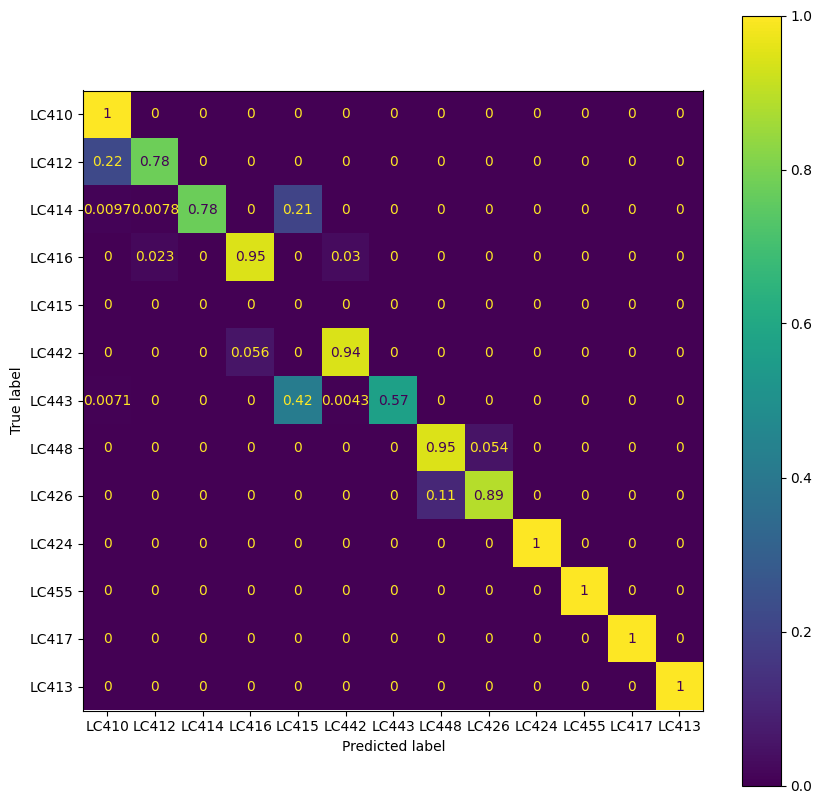

In [19]:
fig, ax = plt.subplots(figsize=(10,10))
cmd = ConfusionMatrixDisplay(confusion_matrix(predicted, ground_truth, normalize='true'), display_labels=confusion_matrix_list(list(data["room"].unique()),
                                                                                                                               list(test_data["room"].unique())))
cmd.plot(ax=ax)
plt.show()

# XGBoost

In [17]:
import xgboost as xgb

In [18]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(data['room'])
y_train = le.transform(train_data["room"].to_numpy())

In [19]:
model = xgb.XGBRFClassifier()
model.fit(train_data.iloc[:,5:], y_train)

XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None, device=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=None, n_jobs=None,
                num_parallel_tree=None, objective='multi:softprob',
                random_state=None, reg_alpha=None, ...)

In [20]:
preds = model.predict(test_data.iloc[:,5:])
ground_truth = le.transform(test_data["room"].to_numpy())
np.sum(preds == ground_truth)/len(ground_truth)

0.9112122936824132

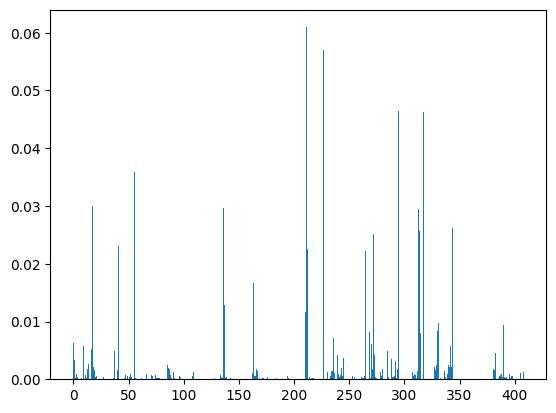

In [47]:
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

In [59]:
importancias = model.feature_importances_
AP_columns = data.columns[5:]
# Crie um DataFrame com as importâncias das características
df_importancias = pd.DataFrame({'Feature': AP_columns, 'Importance': importancias})

# Ordene as características por importância
df_importancias = df_importancias.sort_values(by='Importance', ascending=False)

# Obtenha os nomes das top 50 características mais importantes
top_50_caracteristicas = df_importancias.head(20)['Feature']


# tLoc

In [54]:
def get_bernolli_parameters(data):
  bernolli_parameters = dict()
  splitted_data = data.groupby(['room'])
  for (id, df) in splitted_data:
    #df = df.loc[:, (df != 0).any(axis=0)]
    aps = df.columns[5:]
    probabilities = dict()
    for ap in aps:
      probabilities[str(ap)] = (df[ap] == 0).sum() / df.shape[0]

    bernolli_parameters[str(id[0])] = probabilities

  return bernolli_parameters


In [55]:
a = get_bernolli_parameters(train_data)

In [56]:
def get_gaussian_parameters(data):
  gaussian_parameters = dict()
  splitted_data = data.groupby(['room'])
  for (id, df) in splitted_data:
    #df = df.loc[:, (df != 0).any(axis=0)]
    aps = df.columns[5:]
    mean = dict()
    std = dict()
    for ap in aps:
      data_to_use = df[ap][df[ap] != 0]
      if len(data_to_use) == 0:
        mean[str(ap)] = 0
        std[str(ap)] = 0

      else:
        mean[str(ap)] = data_to_use.mean()
        std[str(ap)] = data_to_use.std()


    gaussian_parameters[str(id[0])] = {"mean": mean, "std": std}

  return gaussian_parameters

In [57]:
b = get_gaussian_parameters(train_data)

In [25]:
aps = train_data.columns[5:]
spaces = a.keys()

In [26]:
n_of_train_data = dict()
for space in spaces:
  for_each_aps = dict()
  df = train_data[train_data["room"] == space]
  n = df.shape[0]
  #df = df.loc[:, (df != 0).any(axis=0)]
  #aps = df.columns[2:]
  for ap in aps:
    for_each_aps[str(ap)] = n

  n_of_train_data[str(space)] = for_each_aps



In [27]:
from scipy.special import gamma
from scipy.special import hyp2f1

def cumulative_distribution_function_of_t_student(x, v):

        return 0.5 + x * gamma((v + 1) / 2) * hyp2f1(1 / 2, (v + 1) / 2, 3 / 2, -(x ** 2) / v) / (
                np.sqrt(v * np.pi) * gamma(v / 2))
        #return 10 + x * gamma((v + 1) / 2) * hyp2f1(1 / 2, (v + 3) / 2, 3 / 2, -(x ** 2) / v) / (
        #        np.sqrt(v * np.pi) * gamma(v / 2))

In [28]:
def cumulative_distribution_function_of_power(power, mu, phi, sigma, v):

        cdf = phi * np.heaviside(power, 1) + (1 - phi) * cumulative_distribution_function_of_t_student(
            (power - mu) / sigma, v)
        
        return cdf

In [29]:
import scipy
def approximate_position_density_function_given_router(power, mu, phi, sigma, num_samples_per_ap, t_score_alpha):

  v = np.ceil(num_samples_per_ap * (1 - phi) - 1)
  v = np.where(v <= 0, 1, v)

  t_score = scipy.stats.t.ppf(0.5 + t_score_alpha, v)

  density_function = cumulative_distribution_function_of_power(power + t_score * sigma, mu, phi, sigma, v) - cumulative_distribution_function_of_power(
            power - t_score * sigma, mu, phi, sigma, v)  # power, mu, phi, sigma, v

  return density_function



In [30]:
n_tests = 0
correct = 0
i = 0
predictions = []
ground_truth = []
for _, eita in test_data.iterrows():

  probability_result = []
  for space in spaces:
    aps = np.array(list(n_of_train_data[space].keys()))
    n = np.array(list(n_of_train_data[space].values()))
    phi = np.array(list(a[space].values()))
    mu = np.array(list(b[space]["mean"].values()))
    rss = np.array(list(eita[aps]))
    s = 4
    n = 30
    Ps = approximate_position_density_function_given_router(rss, mu, phi, s, n, 0.05)

    probability_result.append(np.prod(Ps))
  n_tests += 1
  gt = eita["room"]
  ground_truth.append(gt)
  
  prediction = list(spaces)[probability_result.index(max(probability_result))]
  predictions.append(prediction)
  if prediction == gt:
    correct += 1
    print("Correct!")

  print("Iteration: " + str(n_tests))
  print("Prediction: " + str(prediction))
  print("Ground truth: " + str(gt))
  print("Precision: " + str(correct/n_tests))
  print("=-="*5)
  i += 1


Correct!
Iteration: 1
Prediction: LC415
Ground truth: LC415
Precision: 1.0
=-==-==-==-==-=
Correct!
Iteration: 2
Prediction: LC443
Ground truth: LC443
Precision: 1.0
=-==-==-==-==-=
Correct!
Iteration: 3
Prediction: LC424
Ground truth: LC424
Precision: 1.0
=-==-==-==-==-=
Correct!
Iteration: 4
Prediction: LC417
Ground truth: LC417
Precision: 1.0
=-==-==-==-==-=
Correct!
Iteration: 5
Prediction: LC442
Ground truth: LC442
Precision: 1.0
=-==-==-==-==-=
Correct!
Iteration: 6
Prediction: LC416
Ground truth: LC416
Precision: 1.0
=-==-==-==-==-=
Correct!
Iteration: 7
Prediction: LC417
Ground truth: LC417
Precision: 1.0
=-==-==-==-==-=
Correct!
Iteration: 8
Prediction: LC448
Ground truth: LC448
Precision: 1.0
=-==-==-==-==-=
Correct!
Iteration: 9
Prediction: LC426
Ground truth: LC426
Precision: 1.0
=-==-==-==-==-=
Correct!
Iteration: 10
Prediction: LC417
Ground truth: LC417
Precision: 1.0
=-==-==-==-==-=
Correct!
Iteration: 11
Prediction: LC413
Ground truth: LC413
Precision: 1.0
=-==-==-==-==

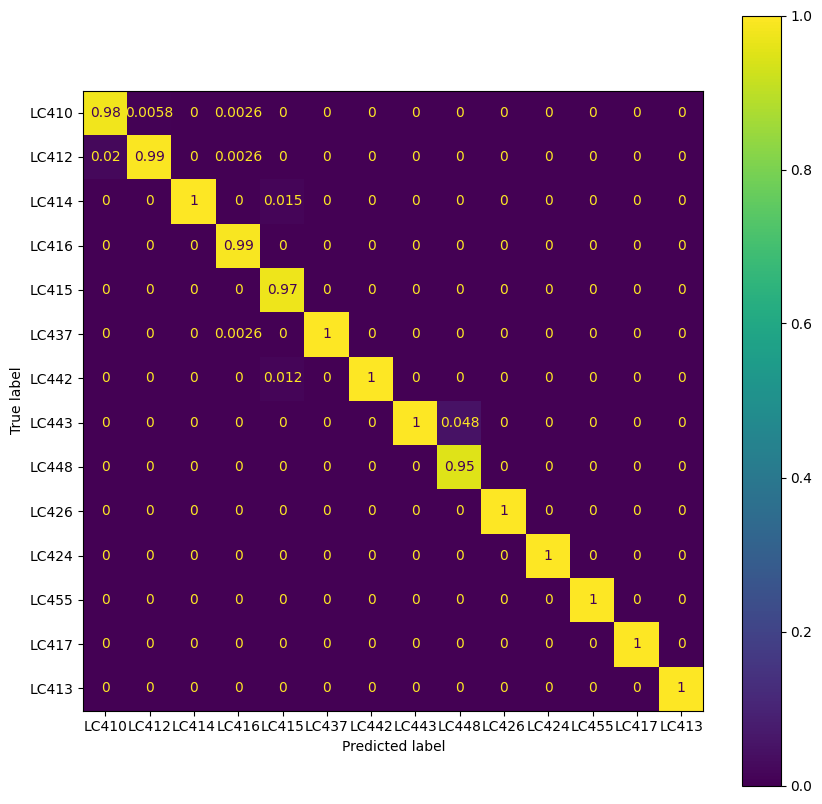

In [31]:
fig, ax = plt.subplots(figsize=(10,10))
cmd = ConfusionMatrixDisplay(confusion_matrix(predictions, ground_truth, normalize='pred'), display_labels=list(data["room"].unique()))
cmd.plot(ax=ax)
plt.show()

# New data test

In [11]:
test_data = pd.read_csv("new_data.csv", index_col=0)

In [110]:
test_data = test_data.fillna(min_value - 1)
test_data.iloc[:, 4:] = test_data.iloc[:, 4:] + (min_value - 1)*(-1)

In [111]:
test_data_aps = test_data.columns[4:]
data_aps = data.columns[5:]

In [112]:
new_columns_for_test_data = list(set(data_aps) - set(test_data_aps))

In [113]:
test_data[new_columns_for_test_data] = 0.0

C:\Users\merte\AppData\Local\Temp\ipykernel_11728\13149992.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_data[new_columns_for_test_data] = 0.0
C:\Users\merte\AppData\Local\Temp\ipykernel_11728\13149992.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_data[new_columns_for_test_data] = 0.0
C:\Users\merte\AppData\Local\Temp\ipykernel_11728\13149992.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joini

In [114]:
new_order_columns = np.delete(data.columns, np.where(data.columns == 'device_id'))


In [115]:
test_data = test_data[new_order_columns]

In [120]:
# Test KNN
predicted = neigh.predict(test_data.iloc[:,4:])
ground_truth = test_data["room"].to_numpy()
np.sum(predicted == ground_truth)/len(ground_truth)

0.77

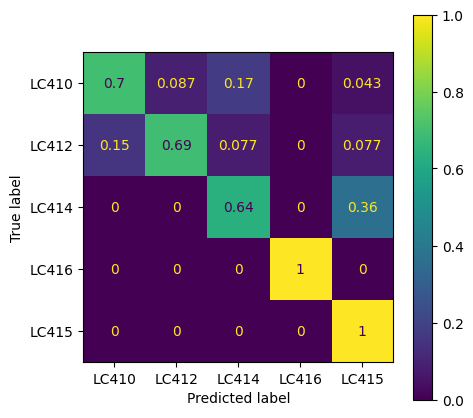

In [121]:
fig, ax = plt.subplots(figsize=(5,5))
cmd = ConfusionMatrixDisplay(confusion_matrix(predicted, ground_truth, normalize='true'), display_labels=list(data["room"].unique()))
cmd.plot(ax=ax)
plt.show()

In [117]:
# Test XGBoost
predicted = model.predict(test_data.iloc[:,4:])
ground_truth = le.transform(test_data["room"].to_numpy())
np.sum(predicted == ground_truth)/len(ground_truth)

0.78

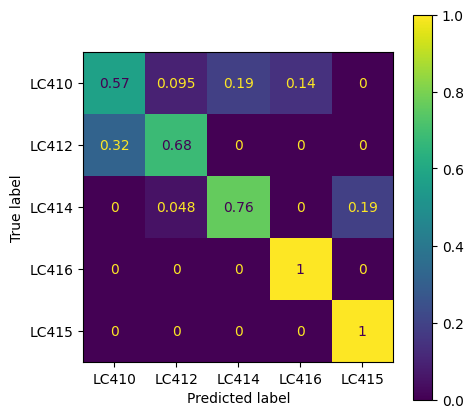

In [71]:
fig, ax = plt.subplots(figsize=(5,5))
cmd = ConfusionMatrixDisplay(confusion_matrix(predicted, ground_truth, normalize='true'), display_labels=list(data["room"].unique()))
cmd.plot(ax=ax)
plt.show()

In [118]:
n_tests = 0
correct = 0
i = 0
predicted = []
ground_truth = []
for _, eita in test_data.iterrows():

  probability_result = []
  for space in spaces:
    aps = np.array(list(n_of_train_data[space].keys()))
    n = np.array(list(n_of_train_data[space].values()))
    phi = np.array(list(a[space].values()))
    mu = np.array(list(b[space]["mean"].values()))
    rss = np.array(list(eita[aps]))
    s = 4
    n = 30
    Ps = approximate_position_density_function_given_router(rss, mu, phi, s, n, 0.05)

    probability_result.append(np.prod(Ps))
  n_tests += 1
  gt = eita["room"]
  ground_truth.append(gt)
  
  prediction = list(spaces)[probability_result.index(max(probability_result))]
  predicted.append(prediction)
  if prediction == gt:
    correct += 1
  i += 1

correct/n_tests

0.78

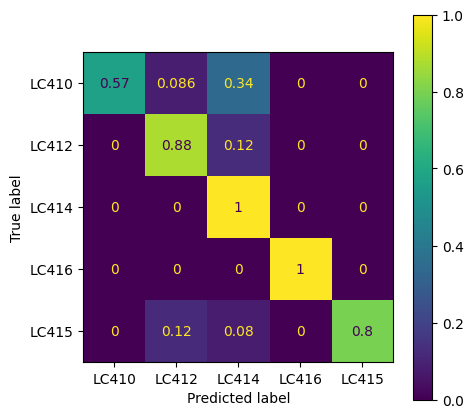

In [119]:
fig, ax = plt.subplots(figsize=(5,5))
cmd = ConfusionMatrixDisplay(confusion_matrix(predicted, ground_truth, normalize='true'), display_labels=list(data["room"].unique()))
cmd.plot(ax=ax)
plt.show()

# Tloc Function

In [20]:
from scipy.special import gamma
from scipy.special import hyp2f1

import scipy

class TLoc:         

    def __init__(self, train_data: pd.DataFrame):
        # self.non_null_minimum_percentage = 0.1
        self.train_data = train_data
        # self.aps = self.get_aps_with_non_zero_minimum_percentage(self.train_data)
        self.aps = list(self.train_data.columns[1:])
        if len(self.aps) == 1:
            self.max_power = int(self.train_data[self.aps].max())
        else:
            self.max_power = int(self.train_data[self.aps].max().max())


        self.spaces = list(self.train_data["room"].unique())

        self.power_probability_masks = {}
        self.power_prior_probability_distribution = {}
        self.eps = 1e-5


    def get_aps_with_non_zero_minimum_percentage(self, data):
        percentage_of_non_zeros = (data.iloc[:, 5:] != 0).sum() / data.shape[0]
        return data.columns[5:][percentage_of_non_zeros >= self.non_null_minimum_percentage]
    


    def get_mu_and_phi_estimation(self, data, router):
        mu = []
        phi = []
        data_of_router = data[["room", router]]
        for space in self.spaces:
            data_of_router_in_space = data_of_router[data_of_router["room"] == space]

            data_of_router_in_space_without_zero_values = data_of_router_in_space[data_of_router_in_space[router] != 0]
            if len(data_of_router_in_space_without_zero_values) == 0:
                mu.append(0.0)
            else:
                mu.append(data_of_router_in_space_without_zero_values[router].mean())
            phi.append(1 - data_of_router_in_space_without_zero_values.shape[0] / data_of_router_in_space.shape[0])

        return mu, phi



    def train(self):
        for router in self.aps:


            self.power_probability_masks[router] = {}
            self.power_prior_probability_distribution[router] = {}

            mu, phi = self.get_mu_and_phi_estimation(self.train_data, router)


            total_num_samples_in_router = self.train_data[router].shape[0]
            for power in range(0, self.max_power):
                self.power_probability_masks[router][
                    power] = self.approximate_position_density_function_given_router(power, np.array(mu),
                                                                                    np.array(phi))
                num_samples_with_value_power_in_router = (self.train_data[router] == power).sum()

                self.power_prior_probability_distribution[router][
                    power] = num_samples_with_value_power_in_router / total_num_samples_in_router

                    

    def cumulative_distribution_function_of_t_student(self, x, v):

        return 0.5 + x * gamma((v + 1) / 2) * hyp2f1(1 / 2, (v + 1) / 2, 3 / 2, -(x ** 2) / v) / (
                np.sqrt(v * np.pi) * gamma(v / 2))
    
    def cumulative_distribution_function_of_power(self, power, mu, phi, sigma, v):

        cdf = phi * np.heaviside(power, 1) + (1 - phi) * self.cumulative_distribution_function_of_t_student(
            (power - mu) / sigma, v)
        
        return cdf
    

    def approximate_position_density_function_given_router(self, power, mu, phi, sigma=5, num_samples_per_ap=30, t_score_alpha=0.05):

        v = np.ceil(num_samples_per_ap * (1 - phi) - 1)
        v = np.where(v <= 0, 1, v)

        t_score = scipy.stats.t.ppf(0.5 + t_score_alpha, v)

        density_function = self.cumulative_distribution_function_of_power(power + t_score * sigma, mu, phi, sigma, v) - self.cumulative_distribution_function_of_power(
                    power - t_score * sigma, mu, phi, sigma, v)  # power, mu, phi, sigma, v

        return density_function
    

    def pred(self, X_test):

        y_pred = []
        min_prob = self.eps * np.ones(len(self.spaces))

        for _, test_sample in X_test.iterrows():

            distribution_xy_given_bf = np.ones(len(self.spaces))

            for router in self.aps:

                    power = int(test_sample[router])

                    try:
                        prob_p_given_xybfr = self.power_probability_masks[router][power]
                    except KeyError:
                        # print(f"Error predicting router {router}, power {power}")
                        continue
                    


                    prob_p_given_xybfr = np.maximum(prob_p_given_xybfr, min_prob)
                    #prob_p_given_xybfr = prob_p_given_xybfr / prob_p_given_xybfr.sum()
                    #prob_xy_given_pbfr = prob_p_given_xybfr / (
                    #                tloc.eps + tloc.power_prior_probability_distribution[router][power])


                    distribution_xy_given_bf = distribution_xy_given_bf * prob_p_given_xybfr




            room_pred = self.spaces[distribution_xy_given_bf.argmax()]
            y_pred.append(room_pred)

        y_pred = np.array(y_pred)
        ground_truth = np.array(list(test_data["room"]))
        ac = np.sum(y_pred == ground_truth)/len(ground_truth)
        return ac, y_pred, ground_truth







In [21]:
columns_to_train = [train_data.columns[1]] + list(train_data.columns[5:])

In [36]:

tloc = TLoc(train_data[columns_to_train])
tloc.train()

In [37]:
accuracy, prediction, ground_truth = tloc.pred(test_data)

In [38]:
accuracy

0.9239233542022387

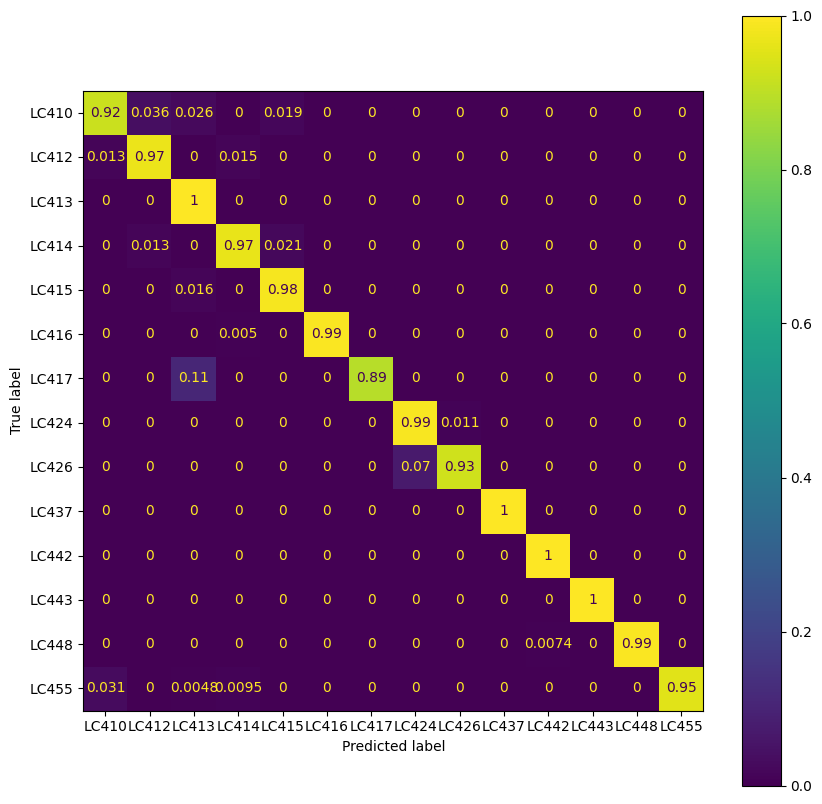

In [91]:
fig, ax = plt.subplots(figsize=(10,10))
cmd = ConfusionMatrixDisplay(confusion_matrix(prediction, ground_truth, normalize='true'), display_labels=list(np.unique(ground_truth)))
cmd.plot(ax=ax)
plt.show()

In [24]:
best_features_for_Guilherme = ["room", '94:d4:69:f9:7d:6b:', '94:d4:69:f9:5b:e6:', '94:d4:69:fd:b1:e8:',
 '94:d4:69:f9:7f:cb:',
 '94:d4:69:f9:7e:4c:',
 '94:d4:69:fd:ac:e8:',
 '94:d4:69:f9:7d:c4:', '94:d4:69:fa:94:4b:',  '94:d4:69:fd:ae:c4:', '94:d4:69:f9:7d:67:',
 '94:d4:69:fd:b1:07:', '94:d4:69:f6:ed:cb:', '94:d4:69:f6:c8:86:', 
 '94:d4:69:fa:94:48:', '94:d4:69:fd:b1:e0:', '94:d4:69:fd:b1:ef:', '94:d4:69:f6:e4:e0:', '94:d4:69:fd:b2:28:',
 '70:d3:79:2e:ba:03:', '94:d4:69:fd:b1:09:'
   ]

In [24]:
best_features_ricardo = ['room',
 '94:d4:69:fd:b1:e3:',
 '94:d4:69:f9:7d:c6:',
 '94:d4:69:fd:ae:c0:',
 '94:d4:69:f9:7d:66:',
 '94:d4:69:f9:5b:e6:',
 '94:d4:69:f6:e4:e4:',
 '94:d4:69:f9:7f:c6:',
 '94:d4:69:f9:7e:44:',
 '94:d4:69:fa:94:44:',
 '70:d3:79:2e:8c:8b:',
 '94:d4:69:fa:9a:00:',
 '70:d3:79:2e:ba:06:',
 '94:d4:69:f6:c5:6c:',
 '94:d4:69:f9:7f:cc:',
 '94:d4:69:fa:9a:04:',
 '94:d4:69:f6:c5:68:',
 '94:d4:69:f7:90:84:',
 '94:d4:69:f9:5b:e8:',
 '94:d4:69:f9:7d:40:',
 '94:d4:69:f9:5b:e4:',
 '94:d4:69:fa:9a:0b:',
 '94:d4:69:f9:7d:69:',
 '94:d4:69:f9:7d:64:',
 '94:d4:69:f6:e4:e0:',
 '70:d3:79:2e:d6:a8:']

### Forward Feature Selection

In [ ]:
best_features = ["room",
   ]
percentage_of_non_zeros = (train_data.iloc[:, 5:] != 0).sum() / train_data.shape[0]
remaining_features = list(train_data.columns[5:][percentage_of_non_zeros >= 0.1] )



for aff in range(100):
    best_acc = -1
    best_feature = None
    best_feature_index = None

    for i, feature in enumerate(remaining_features):
        features_to_use = best_features + [feature]
        X_train_subset = train_data[features_to_use]
        X_test_subset = test_data[features_to_use]
        model = TLoc(X_train_subset)
        
        model.train()
        acc = model.pred(X_test_subset)


        if acc > best_acc:
            print(best_acc)
            best_acc = acc
            best_feature = feature
            best_feature_index = i

    print(aff)
    print(best_feature)

    best_features.append(best_feature)
    remaining_features = np.delete(remaining_features, best_feature_index)


# Analysis Best AP's for Ricardo and Guilherme

In [19]:
best_aps_for_guilherme = best_features_for_Guilherme[1:]

In [20]:
best_aps_for_ricardo = best_features_ricardo[1:]

In [21]:
name_mac_relation[name_mac_relation["ap_mac"].isin(best_aps_for_ricardo)]

,ap_mac,ap_name
4,94:d4:69:f9:5b:e8:,stop&go
6,94:d4:69:f9:7d:64:,Guest-CentraleSupelec
7,94:d4:69:f9:7d:66:,fabrique2024
10,94:d4:69:f9:7d:69:,fabrique2024
21,94:d4:69:fa:9a:00:,eduroam
23,94:d4:69:fa:9a:04:,Guest-CentraleSupelec
28,94:d4:69:fa:9a:0b:,Guest-CentraleSupelec
37,94:d4:69:fd:b1:e3:,CD91
183,94:d4:69:fa:94:44:,Guest-CentraleSupelec
2543,94:d4:69:f6:c5:68:,stop&go


In [22]:
# Fazer uma análise com os valores de treino e de teste lado a lado
# Comparar treino e teste do Guilherme com os melhores APs do Ricardoe vice-versa

## Simple Graphs

In [23]:
data_for_analysis = data[best_aps_for_ricardo]


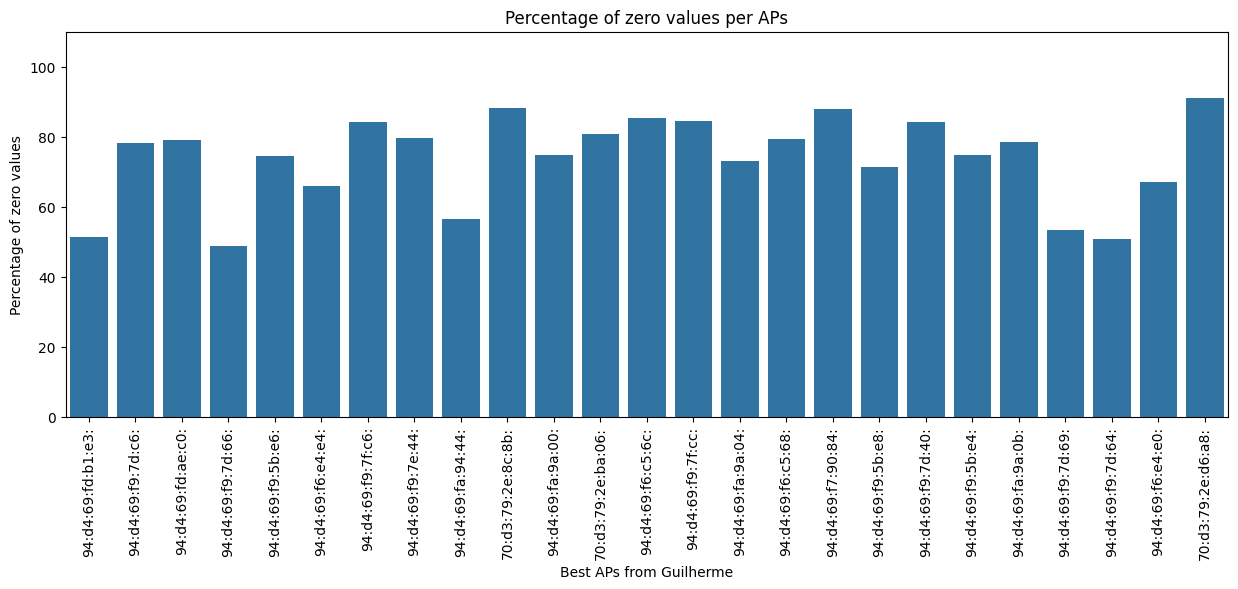

In [24]:
import seaborn as sns
plt.figure(figsize=(15, 5))
zero_percentage = (data_for_analysis == 0).mean() * 100

bar_plot = sns.barplot(x=zero_percentage.index, y=zero_percentage.values)
plt.xlabel('Best APs from Guilherme')
plt.ylabel('Percentage of zero values')
plt.title('Percentage of zero values per APs')
bar_plot.tick_params(axis='x', labelsize=10, rotation=90)
plt.ylim(0, 110)


plt.show()


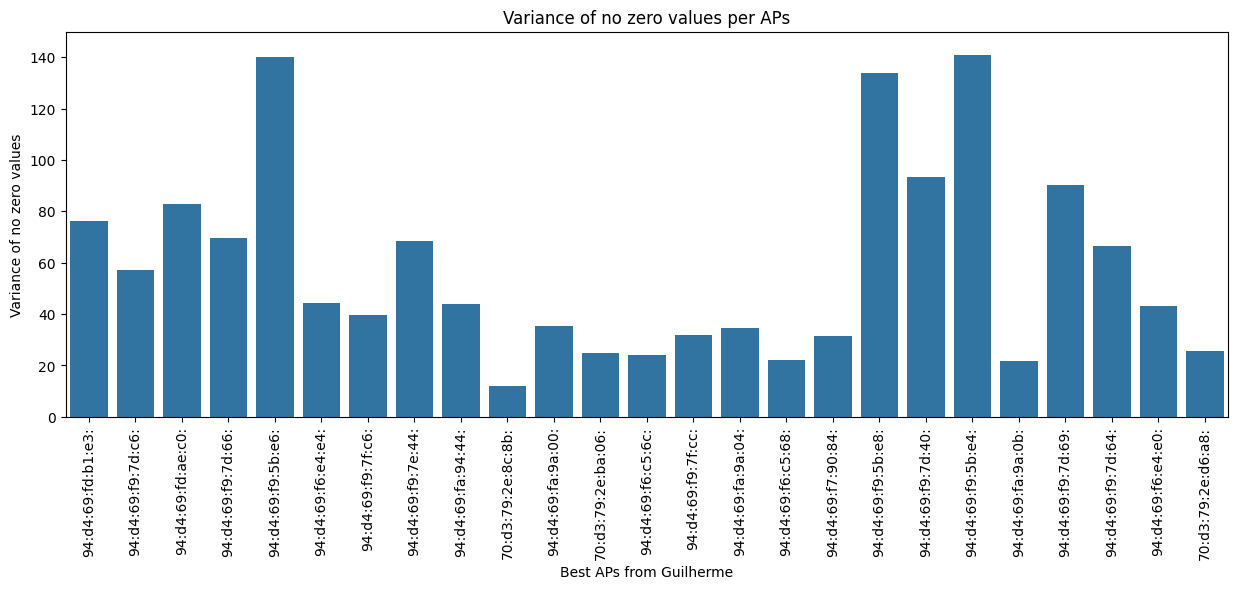

In [25]:
variance_values = data_for_analysis[data_for_analysis > 0].var()

# Ajustando a largura da figura
plt.figure(figsize=(15, 5))

# Plotando com Seaborn
bar_plot = sns.barplot(x=variance_values.index, y=variance_values.values)
plt.xlabel('Best APs from Guilherme')
plt.ylabel('Variance of no zero values')
plt.title('Variance of no zero values per APs')
bar_plot.tick_params(axis='x', labelsize=10, rotation=90)
plt.ylim(0, 150)

plt.show()

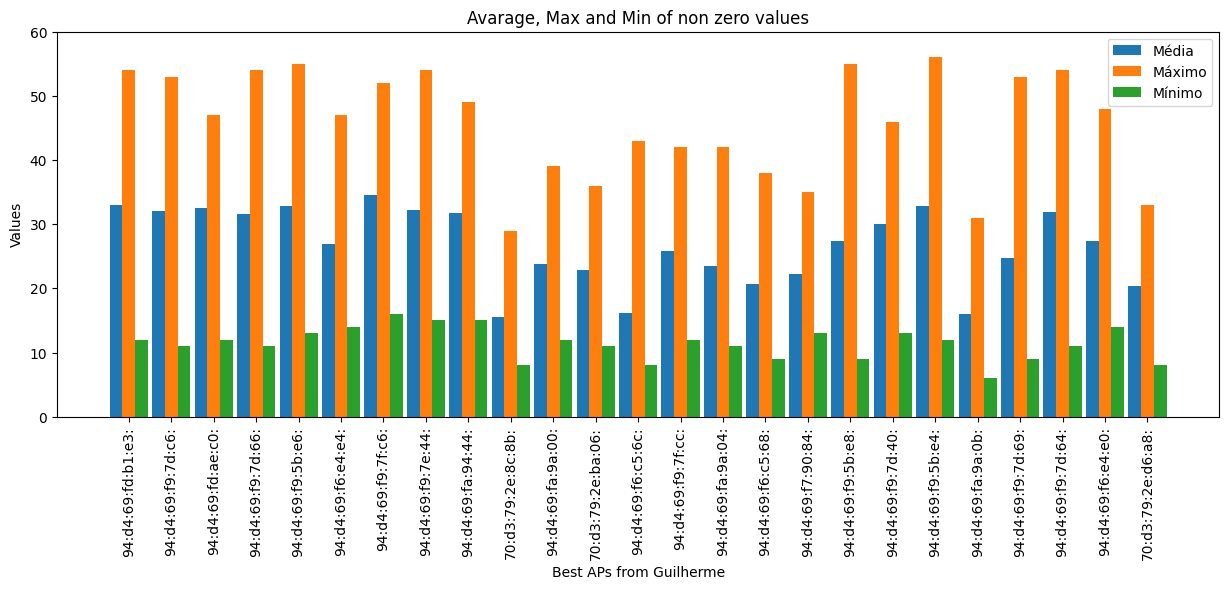

In [26]:
# Calculando a média, valor máximo e valor mínimo dos valores não nulos para cada coluna
mean_values = data_for_analysis[data_for_analysis > 0].mean()
max_values = data_for_analysis[data_for_analysis > 0].max()
min_values = data_for_analysis[data_for_analysis > 0].min()

# Ajustando a largura da figura
plt.figure(figsize=(15, 5))

# Plotando com Seaborn
bar_width = 0.3
index = range(len(mean_values))
plt.bar(index, mean_values, width=bar_width, label='Média')
plt.bar([i + bar_width for i in index], max_values, width=bar_width, label='Máximo')
plt.bar([i + 2 * bar_width for i in index], min_values, width=bar_width, label='Mínimo')

plt.xlabel('Best APs from Guilherme')
plt.ylabel('Values')
plt.title('Avarage, Max and Min of non zero values')
plt.xticks([i + bar_width for i in index], data_for_analysis.columns,)  # Definindo os nomes das colunas
plt.tick_params(axis='x', labelsize=10, rotation=90)
plt.ylim(0, 60)

plt.legend()
plt.show()

## Analysis with random APs

In [27]:
available_aps = [i for i in list(data.columns[5:]) if i not in best_aps_for_guilherme]

random_aps = np.random.choice(available_aps, size=20)
random_data = data[random_aps]

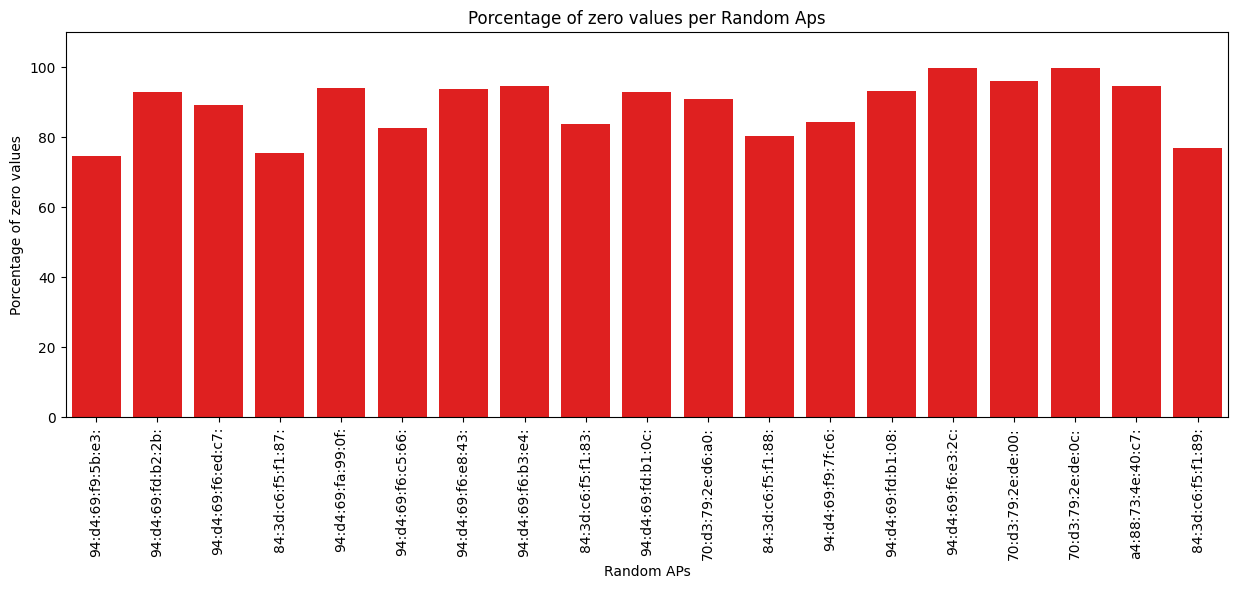

In [28]:
zero_percentage = (random_data == 0).mean() * 100

plt.figure(figsize=(15, 5))

bar_plot = sns.barplot(x=zero_percentage.index, y=zero_percentage.values, color='red')
plt.xlabel('Random APs')
plt.ylabel('Porcentage of zero values')
plt.title('Porcentage of zero values per Random Aps')
bar_plot.tick_params(axis='x', labelsize=10, rotation=90)
plt.ylim(0, 110)

plt.show()


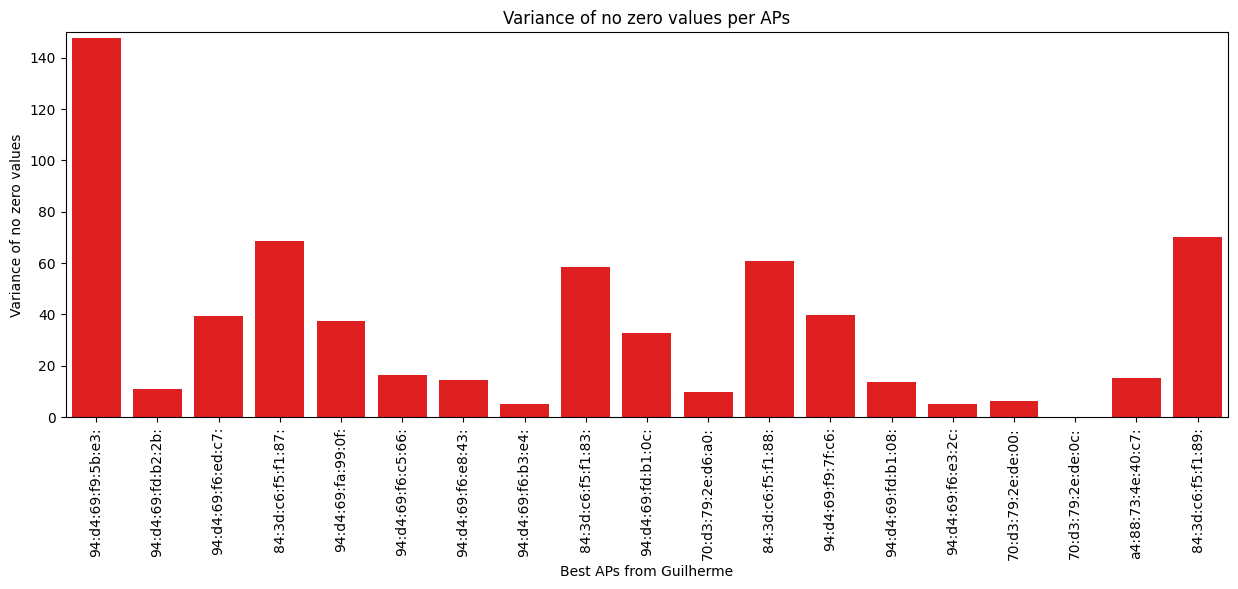

In [29]:
variance_values = random_data[random_data > 0].var()

# Ajustando a largura da figura
plt.figure(figsize=(15, 5))

# Plotando com Seaborn
bar_plot = sns.barplot(x=variance_values.index, y=variance_values.values, color='red')
plt.xlabel('Best APs from Guilherme')
plt.ylabel('Variance of no zero values')
plt.title('Variance of no zero values per APs')
bar_plot.tick_params(axis='x', labelsize=10, rotation=90)
plt.ylim(0, 150)

plt.show()

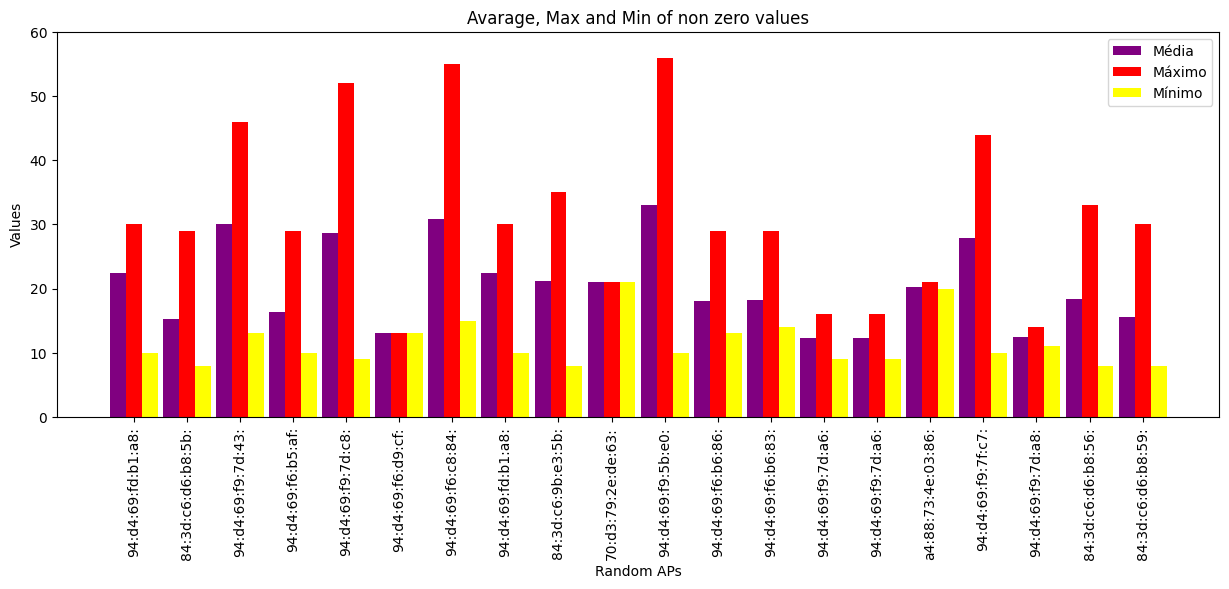

In [61]:
# Calculando a média, valor máximo e valor mínimo dos valores não nulos para cada coluna
mean_values = random_data[random_data > 0].mean()
max_values = random_data[random_data > 0].max()
min_values = random_data[random_data > 0].min()

# Ajustando a largura da figura
plt.figure(figsize=(15, 5))

# Plotando com Seaborn
bar_width = 0.3
index = range(len(mean_values))
plt.bar(index, mean_values, width=bar_width, label='Média', color="purple")
plt.bar([i + bar_width for i in index], max_values, width=bar_width, label='Máximo', color="red")
plt.bar([i + 2 * bar_width for i in index], min_values, width=bar_width, label='Mínimo', color="yellow")

plt.xlabel('Random APs')
plt.ylabel('Values')
plt.title('Avarage, Max and Min of non zero values')
plt.xticks([i + bar_width for i in index], random_data.columns,)  # Definindo os nomes das colunas
plt.tick_params(axis='x', labelsize=10, rotation=90)
plt.ylim(0, 60)

plt.legend()
plt.show()

## Comparing test and train

In [117]:
test_data = data[data["device_id"] == "R" ]
train_data = data[data["device_id"] != "R"]

data_for_analysis_test = test_data[best_aps_for_ricardo]
data_for_analysis_train = train_data[best_aps_for_ricardo]


available_aps = [i for i in list(data.columns[5:]) if i not in best_aps_for_ricardo]

random_aps = np.random.choice(available_aps, size=len(best_aps_for_ricardo))

random_data_for_analysis_test = test_data[random_aps]
random_data_for_analysis_train = train_data[random_aps]




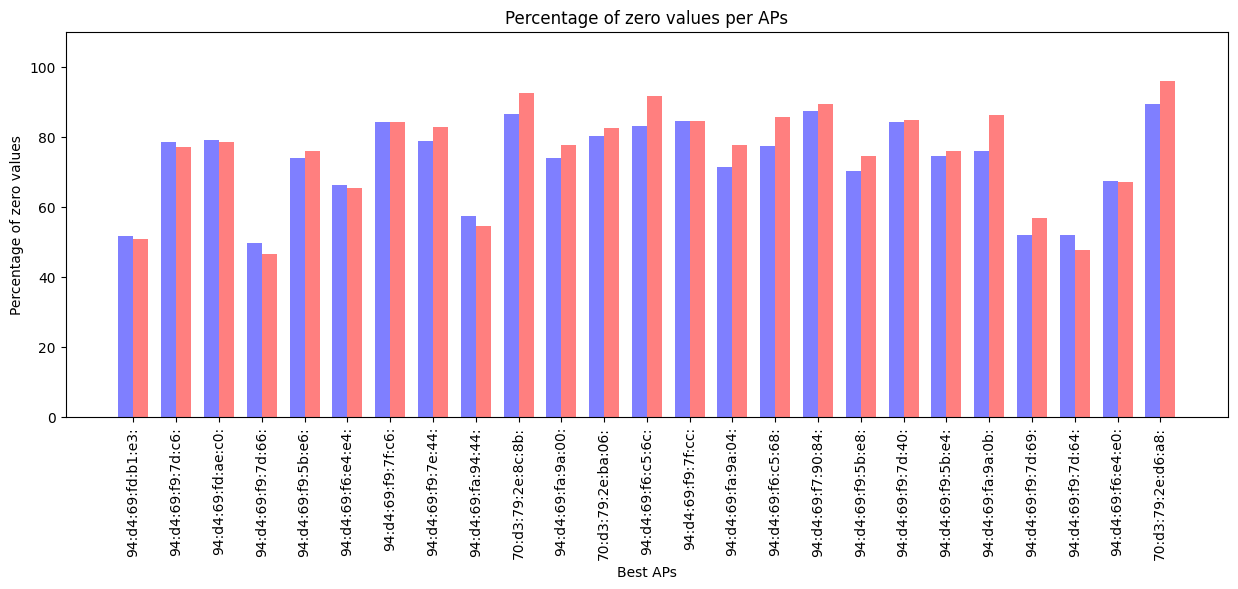

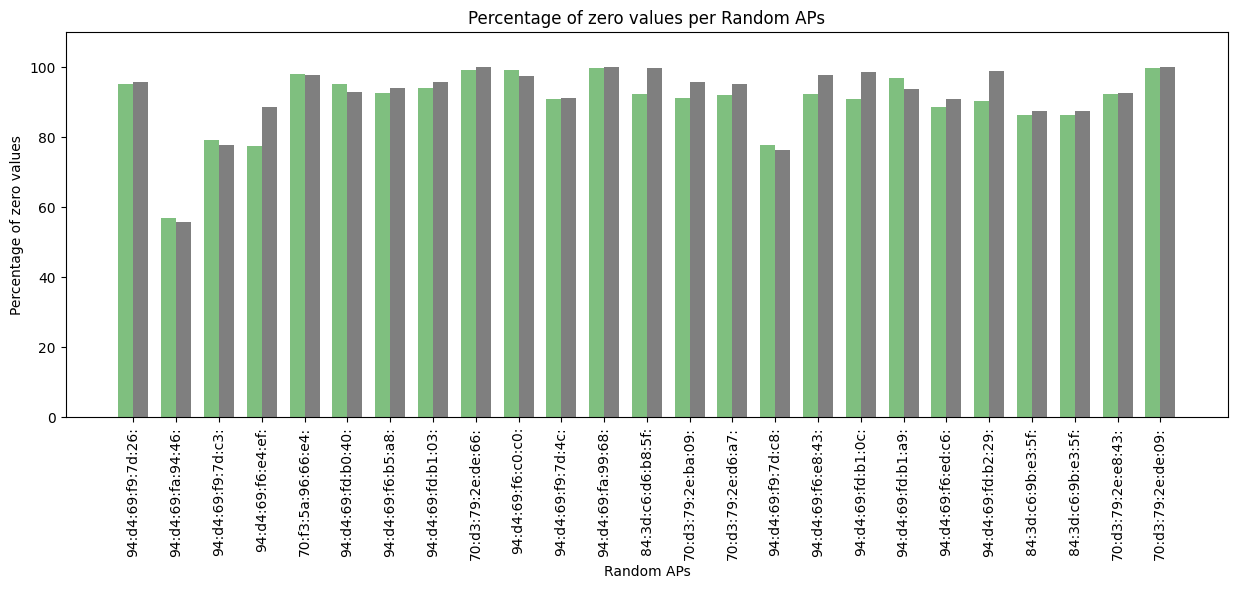

In [118]:
import seaborn as sns
plt.figure(figsize=(15, 5))
zero_percentage_test = (data_for_analysis_test == 0).mean() * 100
zero_percentage_train = (data_for_analysis_train == 0).mean() * 100

bar_width = 0.35
index = np.arange(len(zero_percentage_test))

plt.bar(index, zero_percentage_train.values, bar_width, color='blue', alpha=0.5, label='Train')

plt.bar(index+bar_width, zero_percentage_test.values, bar_width, color='red', alpha=0.5, label='Test')

plt.xlabel('Best APs')
plt.ylabel('Percentage of zero values')
plt.title('Percentage of zero values per APs')
plt.xticks(index + bar_width / 2, zero_percentage_test.index)
plt.tick_params(axis='x', labelsize=10, rotation=90)
plt.ylim(0, 110)


plt.show()


plt.figure(figsize=(15, 5))
zero_percentage_test = (random_data_for_analysis_test == 0).mean() * 100
zero_percentage_train = (random_data_for_analysis_train == 0).mean() * 100

bar_width = 0.35
index = np.arange(len(zero_percentage_test))

plt.bar(index, zero_percentage_train.values, bar_width, color='green', alpha=0.5, label='Train')

plt.bar(index+bar_width, zero_percentage_test.values, bar_width, color='black', alpha=0.5, label='Test')

plt.xlabel('Random APs')
plt.ylabel('Percentage of zero values')
plt.title('Percentage of zero values per Random APs')
plt.xticks(index + bar_width / 2, zero_percentage_test.index)
plt.tick_params(axis='x', labelsize=10, rotation=90)
plt.ylim(0, 110)


plt.show()





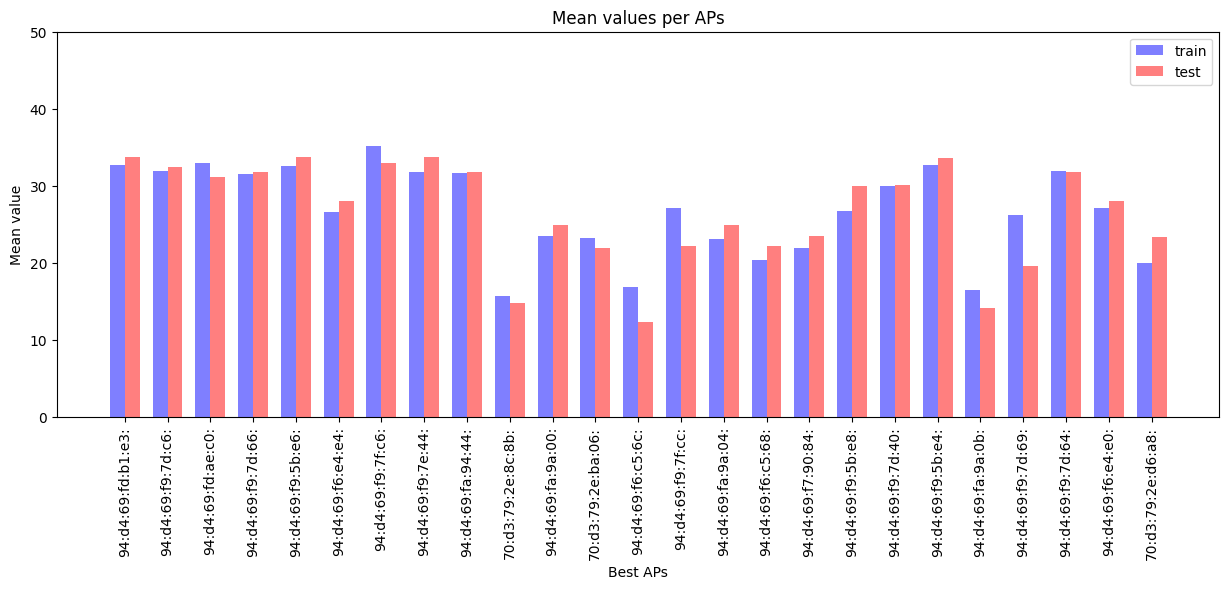

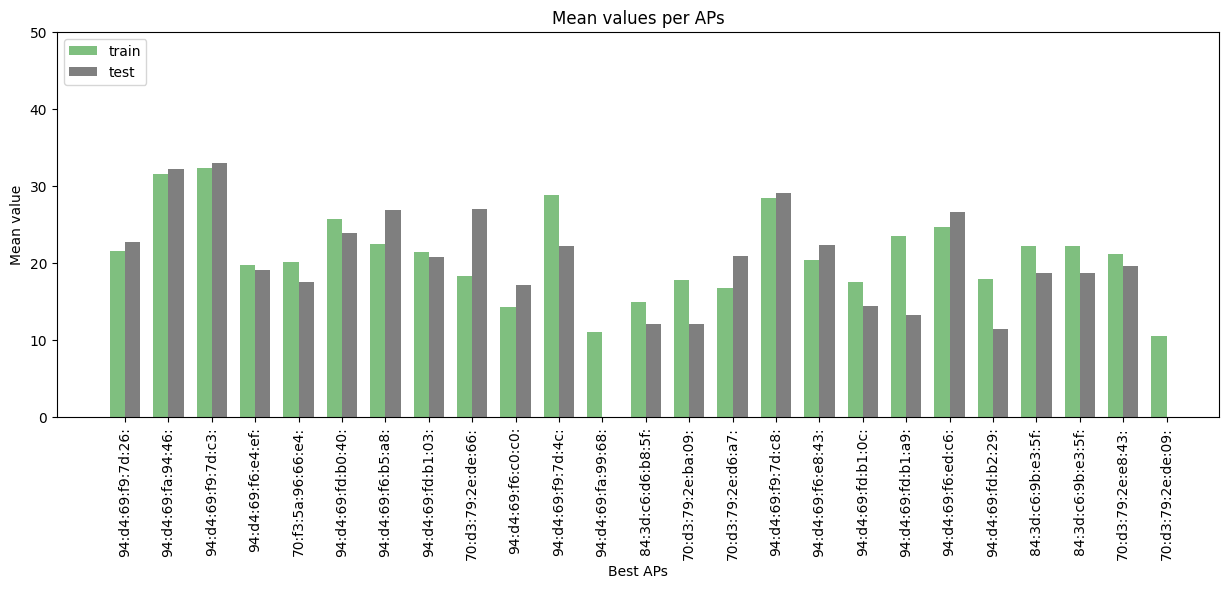

In [119]:
import seaborn as sns
plt.figure(figsize=(15, 5))
mean_values_test = data_for_analysis_test[data_for_analysis_test > 0].mean()
mean_values_train = data_for_analysis_train[data_for_analysis_train > 0].mean()

bar_width = 0.35
index = np.arange(len(mean_values_test))

plt.bar(index, mean_values_train.values, bar_width, color='blue', alpha=0.5, label='Train')

plt.bar(index+bar_width, mean_values_test.values, bar_width, color='red', alpha=0.5, label='Test')
plt.legend(["train", "test"])
plt.xlabel('Best APs')
plt.ylabel('Mean value')
plt.title('Mean values per APs')
plt.xticks(index + bar_width / 2, mean_values_test.index)
plt.tick_params(axis='x', labelsize=10, rotation=90)
plt.ylim(0, 50)


plt.show()


plt.figure(figsize=(15, 5))
mean_values_test = random_data_for_analysis_test[random_data_for_analysis_test > 0].mean()
mean_values_train = random_data_for_analysis_train[random_data_for_analysis_train > 0].mean()

bar_width = 0.35
index = np.arange(len(mean_values_test))

plt.bar(index, mean_values_train.values, bar_width, color='green', alpha=0.5, label='Train')

plt.bar(index+bar_width, mean_values_test.values, bar_width, color='black', alpha=0.5, label='Test')
plt.legend(["train", "test"])
plt.xlabel('Best APs')
plt.ylabel('Mean value')
plt.title('Mean values per APs')
plt.xticks(index + bar_width / 2, mean_values_test.index)
plt.tick_params(axis='x', labelsize=10, rotation=90)
plt.ylim(0, 50)


plt.show()



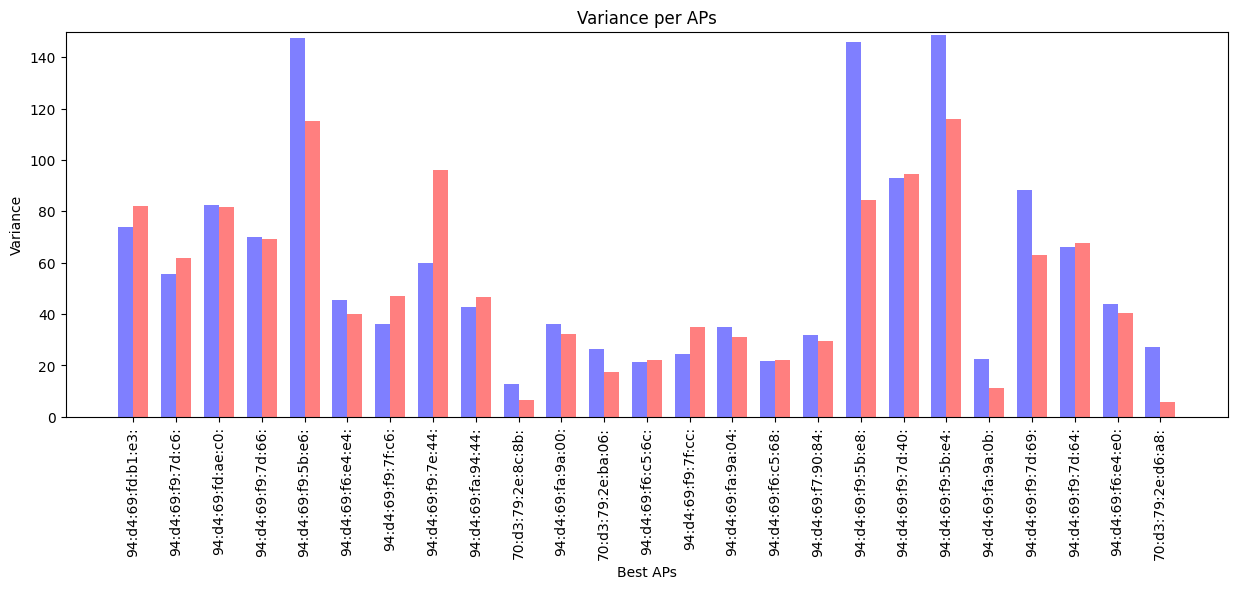

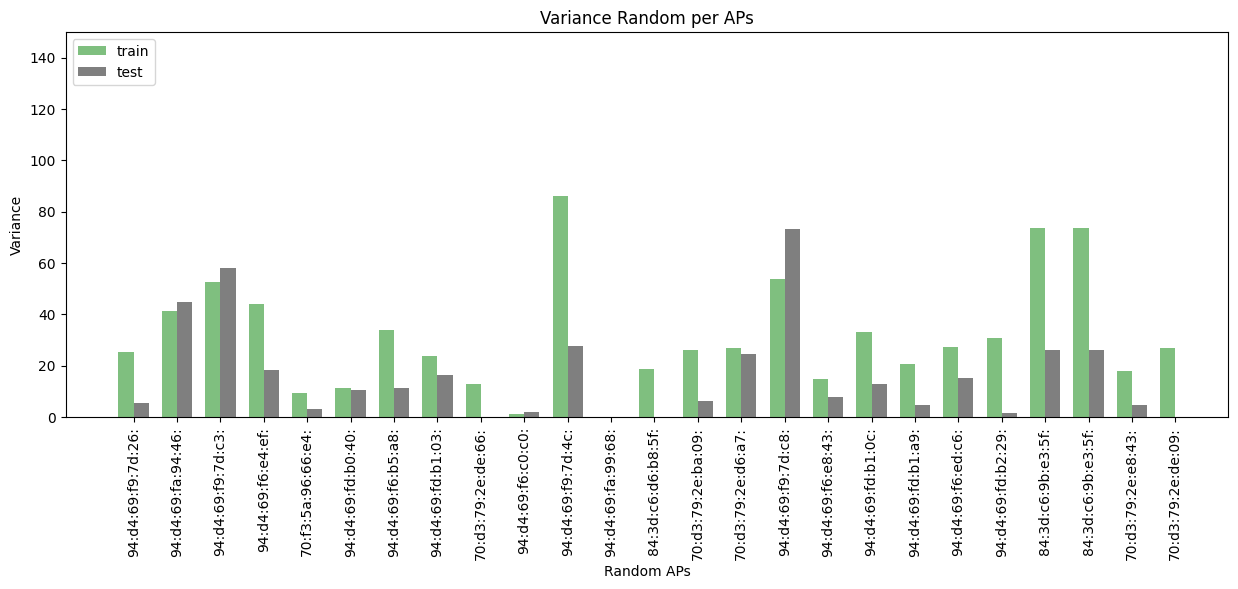

In [120]:
import seaborn as sns
plt.figure(figsize=(15, 5))
variance_values_test = data_for_analysis_test[data_for_analysis_test > 0].var()
variance_values_train = data_for_analysis_train[data_for_analysis_train > 0].var()

bar_width = 0.35
index = np.arange(len(variance_values_test))

plt.bar(index, variance_values_train.values, bar_width, color='blue', alpha=0.5, label='Train')

plt.bar(index+bar_width, variance_values_test.values, bar_width, color='red', alpha=0.5, label='Test')

plt.xlabel('Best APs')
plt.ylabel('Variance')
plt.title('Variance per APs')
plt.xticks(index + bar_width / 2, variance_values_test.index)
plt.tick_params(axis='x', labelsize=10, rotation=90)
plt.ylim(0, 150)


plt.show()


plt.figure(figsize=(15, 5))
variance_values_test = random_data_for_analysis_test[random_data_for_analysis_test > 0].var()
variance_values_train = random_data_for_analysis_train[random_data_for_analysis_train > 0].var()

bar_width = 0.35
index = np.arange(len(variance_values_test))

plt.bar(index, variance_values_train.values, bar_width, color='green', alpha=0.5, label='Train')

plt.bar(index+bar_width, variance_values_test.values, bar_width, color='black', alpha=0.5, label='Test')
plt.legend(["train", "test"])
plt.xlabel('Random APs')
plt.ylabel('Variance')
plt.title('Variance Random per APs')
plt.xticks(index + bar_width / 2, variance_values_test.index)
plt.tick_params(axis='x', labelsize=10, rotation=90)
plt.ylim(0, 150)


plt.show()


## Getting best features

In [95]:
# Uma das ideias seria calcular um peso para as APs -> métrica para os melhores APs
AP_columns = data.columns[5:]
test_data = data[data["device_id"] == "G" ]
train_data = data[data["device_id"] != "G"]

In [96]:
porcentagem_treino = (train_data[AP_columns] == 0).mean() * 100
porcentagem_teste = (test_data[AP_columns] == 0).mean() * 100


features_com_zeros_aceitaveis = porcentagem_treino[porcentagem_treino <= 80].index


# Calcular o módulo da diferença entre as porcentagens
diff_var = abs(train_data[features_com_zeros_aceitaveis][train_data != 0].var() - test_data[features_com_zeros_aceitaveis][test_data != 0].var())

# Ordenar as features pelo módulo da diferença e selecionar as x features menores
x = 40  # número de features a serem selecionadas
features_selecionadas = diff_var.nsmallest(x).index.tolist()

# Improve Results based on feature selection

In [167]:
threshold_max_value = 40
threshold_avarage_value = 20
threshold_variance = 10
threshold_zero_values = 0.85

In [168]:
data_to_filter = data[data.columns[5:]]

porcentagem_nulos = (data_to_filter[data_to_filter == 0].count() / len(data_to_filter))
    
    # Filtra as colunas com porcentagem de valores nulos menor que o limite
colunas_filtradas = porcentagem_nulos[porcentagem_nulos < threshold_zero_values].index
    
    # Calcula a variância, o valor máximo e a média para as colunas filtradas

estatisticas = data_to_filter[data_to_filter > 0][colunas_filtradas].describe()
    
    # Filtra as colunas com variância, valor máximo e média maiores que os mínimos fornecidos
colunas_filtradas2 = estatisticas.columns[(estatisticas.loc['std'] > threshold_variance**(1/2)) & 
                                              (estatisticas.loc['max'] > threshold_max_value) &
                                              (estatisticas.loc['mean'] > threshold_avarage_value)]


In [169]:
columns_to_train = ["room"] + list(colunas_filtradas2)

In [170]:
len(columns_to_train)

99

In [173]:
test_data = data[data["device_id"] == "R" ]
train_data = data[data["device_id"] != "R"]

In [171]:
# columns_to_train = [train_data.columns[1]] + list(train_data.columns[5:])

In [186]:
#slaaa = ["room"] + best_aps_for_guilherme + best_aps_for_ricardo
#slaaa = list(dict.fromkeys(slaaa))

In [31]:
columns_to_train = ["room"] + AP_columns

In [68]:

tloc = TLoc(train_data[["room"] + aaaaa])
tloc.train()


In [69]:
accuracy, prediction, ground_truth = tloc.pred(test_data)
print(accuracy)

0.5336538461538461


In [ ]:
# mean, min, max, var, porcentage of zero, skew, kurtosis, 

# Time Series Analysis

In [114]:
best_aps_for_guilherme = best_features_ricardo[1:]
available_aps = [i for i in list(data.columns[5:]) if i not in best_aps_for_guilherme]

random_aps = np.random.choice(available_aps, size=len(best_aps_for_guilherme))
random_data = data[random_aps]

In [71]:
data["room"].unique()


array(['LC410', 'LC412', 'LC414', 'LC416', 'LC415', 'LC437', 'LC442',
       'LC443', 'LC448', 'LC426', 'LC424', 'LC455', 'LC417', 'LC413'],
      dtype=object)

In [72]:
data["room_part"].unique()

array([1, 2, 3, 4], dtype=int64)

In [92]:
data_of_room_part = data[(data["room"] == "LC455")]
data_of_room_part = data_of_room_part.sort_values(by='timestamp')
data_of_room_part = data_of_room_part.reset_index()


In [169]:
# Parece que quando fazemos o forward, ele tenta pegar um AP que existe só em uma sala

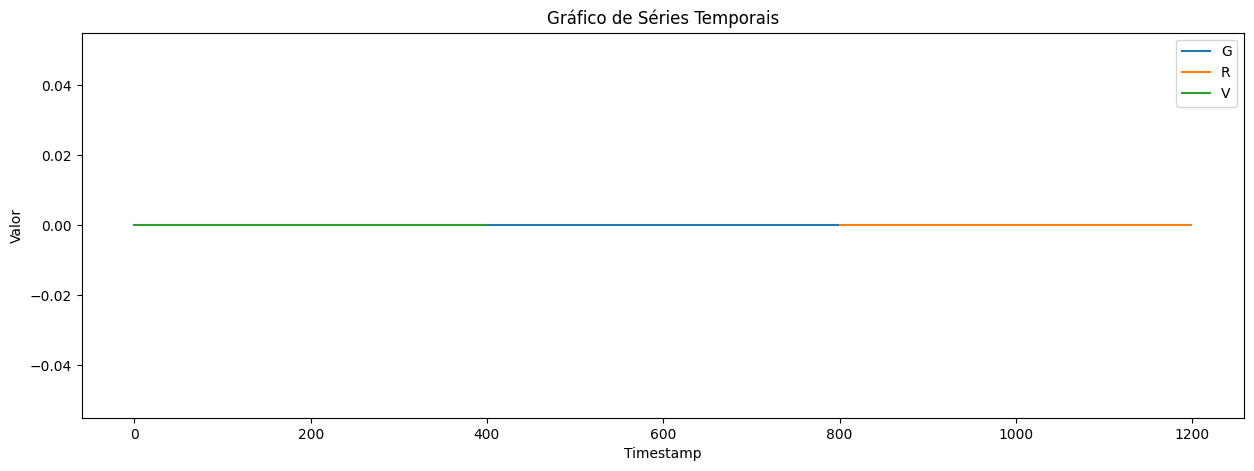

In [135]:
plt.figure(figsize=(15, 5))

for label in np.unique(data_of_room_part["device_id"]):
    plt.plot(data_of_room_part[data_of_room_part["device_id"] == label].index,
              data_of_room_part[data_of_room_part["device_id"] == label][best_aps_for_guilherme[19]], label=label)

# Adicionar rótulos e legenda
plt.xlabel('Timestamp')
plt.ylabel('Valor')
plt.title('Gráfico de Séries Temporais')
plt.legend()
plt.show()

In [202]:
data = data.sort_values(by='timestamp')
data = data.reset_index()


In [ ]:
# APS que estão presentes em várias salas

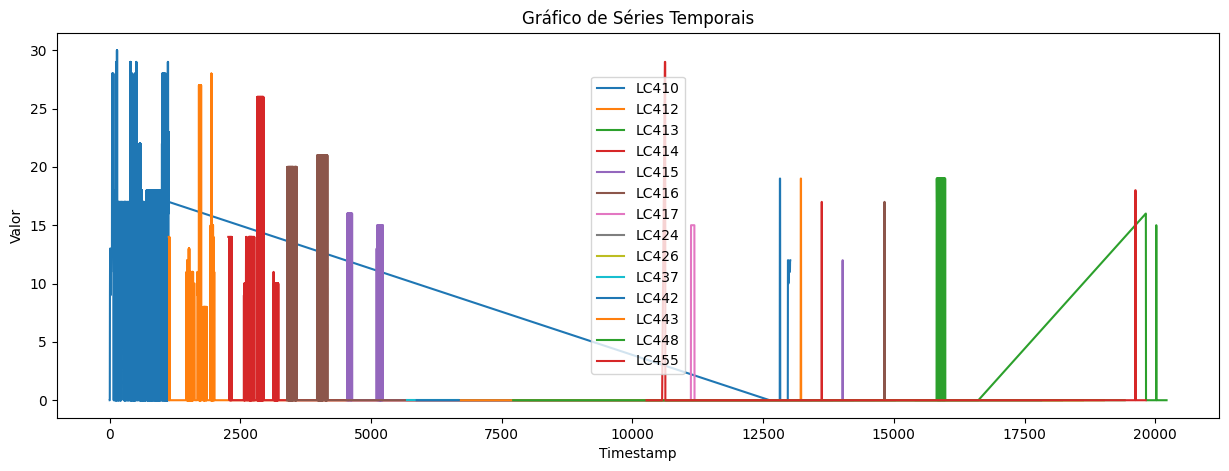

In [271]:
plt.figure(figsize=(15, 5))

for label in np.unique(data["room"]):
    plt.plot(data[data["room"] == label].index,
              data[data["room"] == label][best_aps_for_guilherme[19]], label=label)

# Adicionar rótulos e legenda
plt.xlabel('Timestamp')
plt.ylabel('Valor')
plt.title('Gráfico de Séries Temporais')
plt.legend()
plt.show()

In [ ]:
# Para cada sala, calcular a porcentagem de valores não nulos de todos os APs, somar eles, e pegar os top
# Ter alguma forma de medir o nível de estabilidade do sinal

In [25]:
total_por_sala = data[["room"] + AP_columns].groupby('room').apply(lambda x: len(x))

sinais_por_sala = data[["room"] + AP_columns].groupby('room').apply(lambda x: (x.iloc[:, 1:] != 0).sum())

porcentagem_por_sinal = sinais_por_sala.div(total_por_sala, axis=0) * 100

soma_por_sinal = porcentagem_por_sinal.sum()

soma_por_sinal = soma_por_sinal / soma_por_sinal.sum()


top_20_sinais = soma_por_sinal.nlargest(400)

aaaaa = list(top_20_sinais.index)

In [66]:
std_per_room_per_part = data[["room"] + AP_columns].groupby('room').apply(lambda x: x.std())

num_zeros = (std_per_room_per_part == 0).sum()

colunas_filtradas = num_zeros[num_zeros <= 10].index

std_per_room_per_part_filtrado = std_per_room_per_part[colunas_filtradas]


sum_std_per_room_per_part = std_per_room_per_part_filtrado.sum()

top_20_sinais = sum_std_per_room_per_part.nsmallest(50)
aaaaa = list(top_20_sinais.index)


In [ ]:
# Tentar fazer um pós-processamento dos dados, deixando eles mais estáveis